## Imports

In [161]:
!nvidia-smi

Fri Apr 16 17:48:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |   2425MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [162]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
from PIL import Image

In [163]:
device = torch.device("cuda")

In [164]:
!wget -O content.jpg https://cdn.sozvezdie-tour.ru/images/uploadedfiles/fed20ae1-f278-4db2-b414-63b6dd6142de.jpg
!wget -O style.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

--2021-04-16 17:49:08--  https://cdn.sozvezdie-tour.ru/images/uploadedfiles/fed20ae1-f278-4db2-b414-63b6dd6142de.jpg
Resolving cdn.sozvezdie-tour.ru (cdn.sozvezdie-tour.ru)... 185.10.185.115
Connecting to cdn.sozvezdie-tour.ru (cdn.sozvezdie-tour.ru)|185.10.185.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112495 (110K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>] 109.86K   333KB/s    in 0.3s    

2021-04-16 17:49:09 (333 KB/s) - ‘content.jpg’ saved [112495/112495]

--2021-04-16 17:49:10--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540189 (528K) [image/jpeg]
Sa

In [146]:
imsize = 512

transform = transforms.Compose([transforms.Resize(imsize),
                             transforms.CenterCrop((imsize, imsize)),
                             transforms.ToTensor()])

def load(img_name):
    img = Image.open(img_name)
    img = transform(img).unsqueeze(0)
    return img.to(device, torch.float)


In [147]:
style_img = image_loader("style.jpg")
content_img = image_loader("content.jpg")

In [148]:
style_img.size()

torch.Size([1, 3, 512, 512])

In [149]:
content_img.size()

torch.Size([1, 3, 512, 512])

In [167]:
def show(img):
  img = img.transpose(1, 2).transpose(2, 3).cpu().numpy()
  img = img.squeeze()
  img = (img * 255).astype('uint8')
  plt.figure(figsize=(6, 6))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

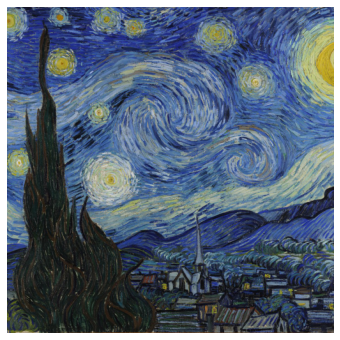

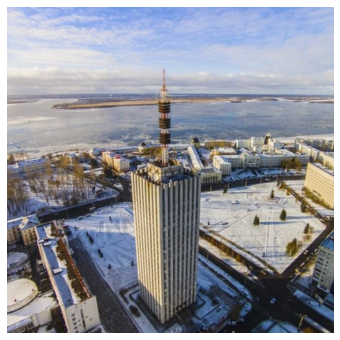

In [168]:
show(style_img)
show(content_img)

## Loss

In [152]:
# Content loss

class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [153]:
# Style loss

def gram_matrix(input):
    _, channels, h, w = input.size()  
    
    features = input.view(channels, h * w)
    G = torch.mm(features, features.t())  

    return G.div(channels * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Load pretrained VGG feature extractor

In [154]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [155]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [156]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [158]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [159]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.768766 Content Loss: 6.719526

run [100]:
Style Loss : 0.742484 Content Loss: 6.601545

run [150]:
Style Loss : 0.715031 Content Loss: 6.500012

run [200]:
Style Loss : 0.672662 Content Loss: 6.431115

run [250]:
Style Loss : 0.637004 Content Loss: 6.369254

run [300]:
Style Loss : 0.613628 Content Loss: 6.312145



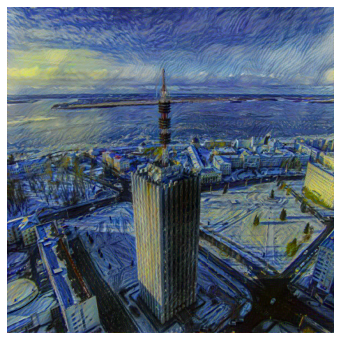

In [170]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

show(output.detach())